# Practice 6. Stochastic Gradient Descent for SVM

Authors: Marc Ballestero and Iris Vukovic

The goal of this practical is to solve the SVM optimization problem in the primal, using stochastic gradient descent. This problem can be formulated as:
$$
  \text{minimize} \qquad f(\mathbf{w}, b, \xi) = \frac{1}{2} \mathbf{w}^T \mathbf{w} + K \sum_i \xi_i \\
  \text{subject to} \qquad y_i(\mathbf{w}^T \mathbf{x}_i + b) \geq 1 - \xi_i, \:\: \xi_i \geq 0.
$$

This problem can be rewritten in an unconstrained way as
$$
\text{minimize} \qquad f(\mathbf{w}, b) = \frac{\lambda}{2} \mathbf{w}^T \mathbf{w} + \sum_{i=0}^m \max{\left(0, 1-y_i(\mathbf{w}^T\mathbf{x}_i + b )\right)}.
$$

This problem can be solved using an stochastic gradient descent algorithm (SGD), which updates the parameters as such

$$
\mathbf{w}_{t+1} \leftarrow \mathbf{w}_t - \gamma_t \left( \lambda \mathbf{w}_t + \left\{
\begin{array}{ll}
0 & \text{if } y_t(\mathbf{w}_t^T \mathbf{x}_t + b) > 1 \\
-y_t \mathbf{x}_t & \text{otherwise}
\end{array}
\right. \right)
$$

$$
b_{t+1} \leftarrow b_t - \gamma_t \left\{ \begin{array}{ll}
0 & \text{if } y_t(\mathbf{w}^T \mathbf{x}_t + b) > 1 \\
-y_t & \text{otherwise}
\end{array}
\right.
$$

Having stated that, let us begin the practical exercises. The next cell imports all the necessary libraries and defines a function to create a dataset to work with.


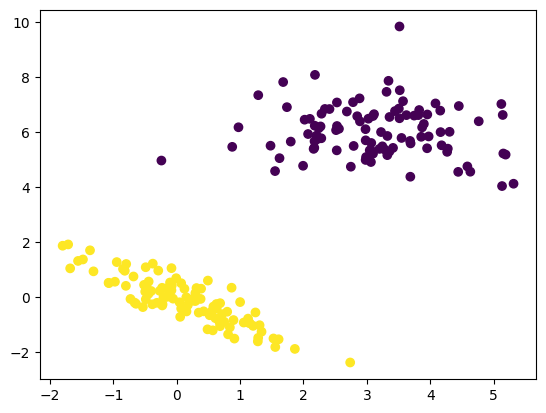

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Function to create the dataset
def create_dataset(n_points, separable=True, seed=42):
    """Function to create a dataset with n_points points"""
    np.random.seed(seed)
    m1 = np.array([0., 0.])
    s1 = np.array([[1, -0.9], [-0.9, 1]])

    m2 = np.array([3., 6.]) if separable else np.array([1., 2.])
    s2 = np.eye(2)

    pos_class = np.random.multivariate_normal(m1, s1, n_points // 2)
    neg_class = np.random.multivariate_normal(m2, s2, n_points // 2 + n_points % 2)

    x = np.concatenate((pos_class, neg_class), axis=0)
    y = np.concatenate((np.ones(n_points // 2), -np.ones(n_points // 2 + n_points % 2)))

    return x.T, y


x, y = create_dataset(200, separable=True)

plt.scatter(x[0, :], x[1, :], c=y)

In [ ]:
# function to plot the separating hyperplanes
def plot_solution(x, y, lamb, w, b, ax=None):
    """Function to plot the solution"""
    if ax is None:
        fig, ax = plt.subplots()

    ax.scatter(x[0, :], x[1, :], c=["orange" if i == 1 else "purple" for i in y])
    xs = np.linspace(-2, 5, 100)
    ys = (-w[0] * xs - b) / w[1]
    ys1 = (-w[0] * xs - b + 1) / w[1]
    ys2 = (-w[0] * xs - b - 1) / w[1]

    ax.plot(xs, ys, 'green')
    ax.plot(xs, ys1, 'g--')
    ax.plot(xs, ys2, 'g--')

    ax.set_xlabel(r"$x$")
    ax.set_ylabel(r"$y$")
    ax.set_title(rf"$\lambda$ = {lamb:.2e}")

    return ax

# function to plot the objective function decay
def plot_decay(f_values, ax=None):
    """Function to plot the solution"""
    if ax is None:
        fig, ax = plt.subplots()

    ax.plot(np.arange(1, len(f_values)+1), np.log(f_values), c="blue")

    ax.set_xlabel("t [Epoch]")
    ax.set_ylabel(r"$\log{f(w_t, b_t)}$")

    return ax


#### (1) Start with the classical stochastic gradient descent, that is, the one in which only one random sample is taken at each iteration. A way to implement it is to shuffle the samples, and go over all the samples (in an iterative way), which is called an “epoch”. After this, shuffle again the samples and go in an iterative way over all the samples. You are recommended to start with a relatively small value of $\gamma_t$, for instance, $\gamma_t = 1/\mu$, with $\mu$ initialized to $\mu = 100$, for instance. The value of $\mu$ is increased after each iteration. You may increase $\mu$ after each iteration by a value of 1, 0.5 or 0.1, for instance. You also may use $\lambda = 10^{-4}$ or $\lambda = 10^{-2}$ for instance. Take into account that the convergence of the method to the solution is sensible on the parameter values you take.


The functions below implement the stochastic gradient descent algorithm proposed in the problem statement.

In [ ]:
# Primal problem function
def primal(x, y, w, b, lamb):
  """Primal problem"""
  return .5 * lamb * w.T @ w + np.sum(np.maximum(0, 1-y*(w.T @ x + b)))


# Stochastic gradient descent function
def sgd(x, y, lamb, mu, dmu, epochs, seed=42):
  """Stochastic gradient descent (one sample)"""
  # Fix a random seed for reproducibility
  np.random.seed(seed)

  # Initialize w and b with random values
  w = np.random.rand(x.shape[0])
  b = np.random.rand(1)[0]

  # Initialize a list to save teh values of the objective funcion
  # at each epoch
  f_values = []

  # Start iterating
  for epoch in np.arange(1, epochs+1):

    # Shuffle the data
    perm = np.random.permutation(x.shape[1])
    x = x[:, perm]
    y = y[perm]

    # Update the parameters
    for i in range(x.shape[1]):
      print(f"Epoch {epoch} / {epochs}: {i+1} / {x.shape[1]}", end="\r")
      gamma = 1. / mu
      w = w - gamma * (lamb*w - y[i]*x[:, i]*(y[i] * (w.T @ x[:, i] + b) <= 1))
      b = b + gamma * y[i] * (y[i] * (w.T @ x[:, i] + b) <= 1)

    mu += dmu
    f_values.append(primal(x, y, w, b, lamb))

  return w, b, f_values


Let us perform some experiments with the descent function and different values of $\lambda$, for a separable dataset with 100 samples per class and 50 descent epochs.

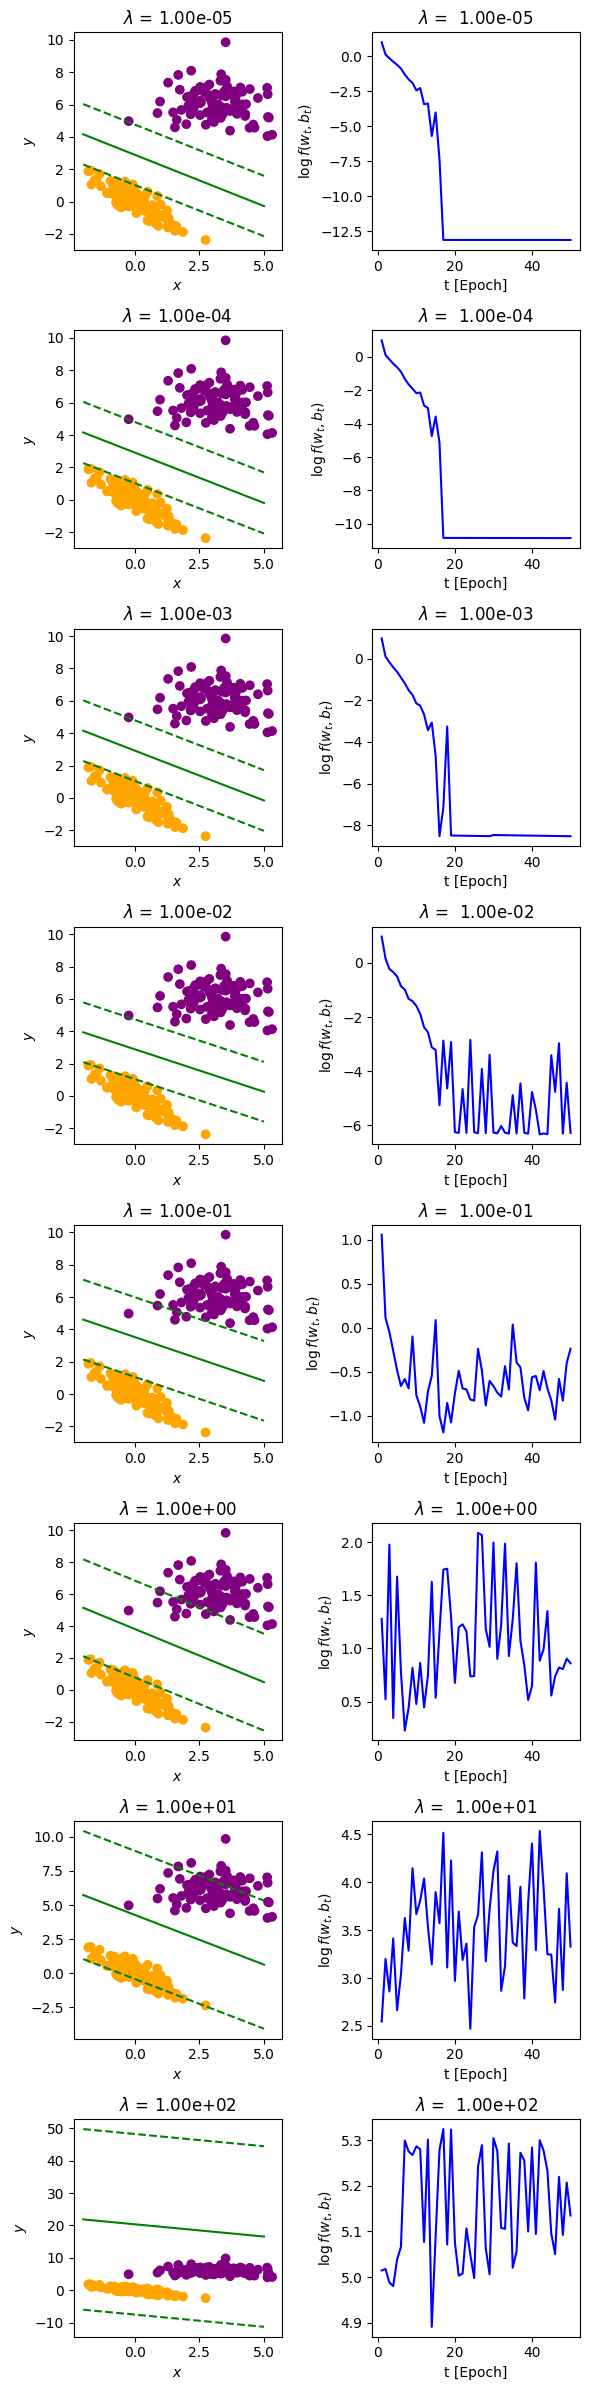

In [ ]:
# Create a separable dataset with 100 points per class
x, y = create_dataset(200, separable=True)

# Create a list with the values of lambda
lambs = [10**i for i in range(-5, 3, 1)]

# Solve the problem
fig, ax = plt.subplots(nrows=8, ncols=2, figsize=(6, 24))
for i, lamb in enumerate(lambs):
    w, b, f_values = sgd(x, y, lamb, 100, 1, 50)

    # Plot the solution
    plot_solution(x, y, lamb, w, b, ax=ax[i, 0])

    # Plot the decay of the objective function
    plot_decay(f_values, ax=ax[i, 1])
    ax[i, 1].set_title(rf"$\lambda$ = {lamb: .2e}")

plt.tight_layout()
plt.show()

As we can see, for values of $\lambda$ between $10^{-5}$ and $10^{-2}$, the hyperplane correctly separates the data, and the support vectors are leaning on the hyperplanes at distance 1 of the separating hyperplane. It works! Note that in the cases where a separating hyperplane is not found, the objective function does not descend over epochs, it wildly oscillates without descending n expectation.

Let us now experiment with the increase of $\mu$ at each epoch, starting with $\mu=100$. We will work with $\lambda = 10^{-4}$.

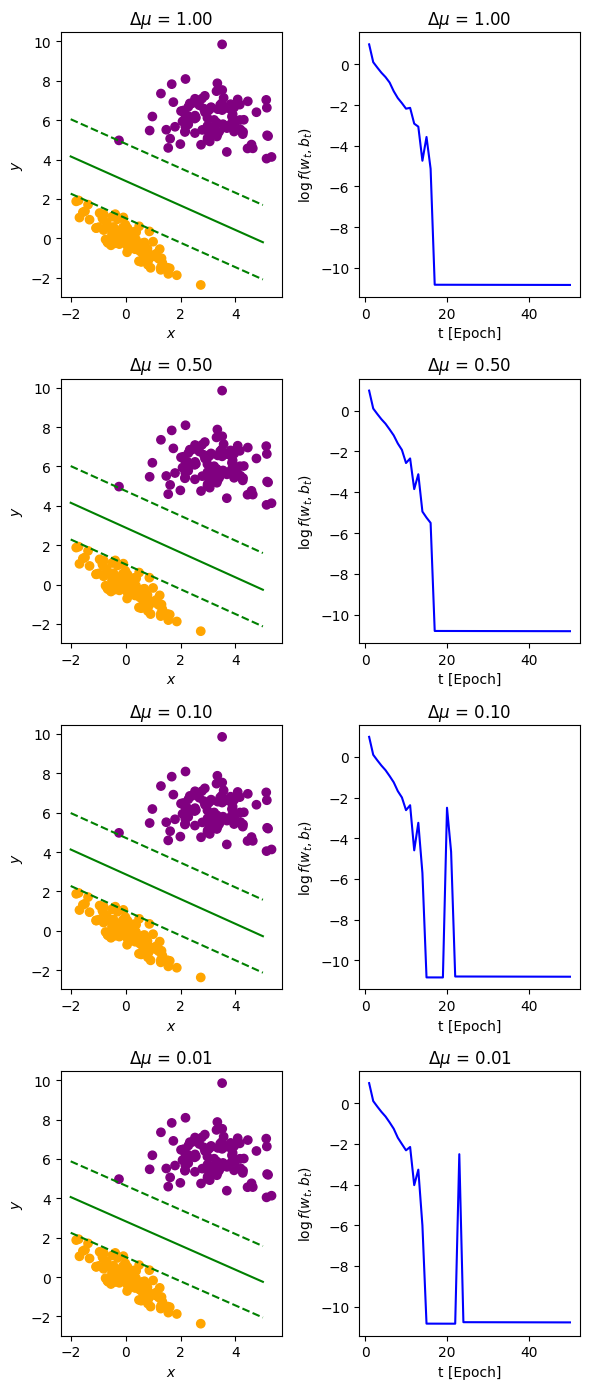

In [ ]:
# Create a separable dataset with 100 points per class
x, y = create_dataset(200, separable=True)

# Create a list with the values of dmu
dmus = [1, 0.5, 0.1, 0.01]

lamb = 1.e-4

# Solve the problem
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(6, 14))
for i, dmu in enumerate(dmus):
    w, b, f_values = sgd(x, y, lamb, 100, dmu, 50)

    # Plot the solution
    plot_solution(x, y, lamb, w, b, ax=ax[i, 0])
    ax[i, 0].set_title(rf"$\Delta\mu$ = {dmu:.2f}")

    # Plot the decay of the objective function
    plot_decay(f_values, ax=ax[i, 1])
    ax[i, 1].set_title(rf"$\Delta\mu$ = {dmu:.2f}")

    # Plot the
plt.tight_layout()
plt.show()

The algorithm works and correctly separates the data for all the proposed  values of $\Delta\mu$.

#### (2) Perform some experiments with the mini-batch. You may try different number of samples to construct the mini-batches, e.g. 10 or 50 samples. In order to simplify the problem and be able to perform comparisons between the stochastic and minibatch, take a number of samples of 200 (100 at each class, as performed in the previous lab) and mini-batches with a size that of 10, 20 or 50, for instance. After each epoch you perform a shuffle of the samples and construct again the mini-batches.

The stochastic mini-batch algorithm is similar to the classical one, but in this case we are performing SGD algorithm on, let's say, a set $S$ that has $M$ elements. The algorithm is as follows:

$$
\mathbf{w}_{t+1} \leftarrow \mathbf{w}_t - \gamma_t \left( \lambda \mathbf{w} + \sum_{k\in S}
\left\{
\begin{array}{ll}
0 & \text{if } y_k(\mathbf{w}^T \mathbf{x}_k + b) > 1 \\
-y_k \mathbf{x}_k & \text{otherwise}
\end{array}
\right. \right)
$$

$$
b_{t+1} \leftarrow b_t - \gamma_t \left( \sum_{k\in S} \left\{ \begin{array}{ll}
0 & \text{if } y_k(\mathbf{w}^T \mathbf{x}_k + b) > 1 \\
-y_k & \text{otherwise}
\end{array}
\right. \right)
$$


Let us first code the function that will perform SGD with mini-batches.

In [ ]:
# Stochastic gradient descent function with mini-barches
def batch_sgd(x, y, lamb, mu, dmu, epochs, batch_size=10, seed=42):
  """Stochastic gradient descent (mini batch)"""
  # Fix a random seed for reproducibility
  np.random.seed(seed)

  # Initialize w and b with random values
  w = np.random.rand(x.shape[0])
  b = np.random.rand(1)[0]

  # Initialize a list to save teh values of the objective funcion
  # at each epoch
  f_values = []

  # Calculate the number of mini-batches
  n_batches = x.shape[1] // batch_size

  # Start iterating
  for epoch in np.arange(1, epochs+1):

    # Shuffle the data
    perm = np.random.permutation(x.shape[1])
    x = x[:, perm]
    y = y[perm]

    # Update the parameters
    for i in range(n_batches):
      print(f"Epoch {epoch} / {epochs}: {i+1} / {n_batches}", end="\r")

      # Slice each batch
      x_batch = x[:, i*batch_size: (i+1)*batch_size]
      y_batch = y[i*batch_size: (i+1)*batch_size]

      # Compute the inner sums for each batch
      w_sum = 0.
      b_sum = 0.
      for j in range(x_batch.shape[1]):
        w_sum -= y_batch[j]*x_batch[:, j]*(y_batch[j] * (w.T @ x_batch[:, j] + b) <= 1)
        b_sum -= y_batch[j] * (y_batch[j] * (w.T @ x_batch[:, j] + b) <= 1)

      gamma = 1. / mu
      w = w - gamma * (lamb*w + w_sum)
      b = b - gamma * b_sum

    mu += dmu
    f_values.append(primal(x, y, w, b, lamb))

  return w, b, f_values


Now we experiement applying the stochastic minibatch algorithm onto varying sizes of minibatches.

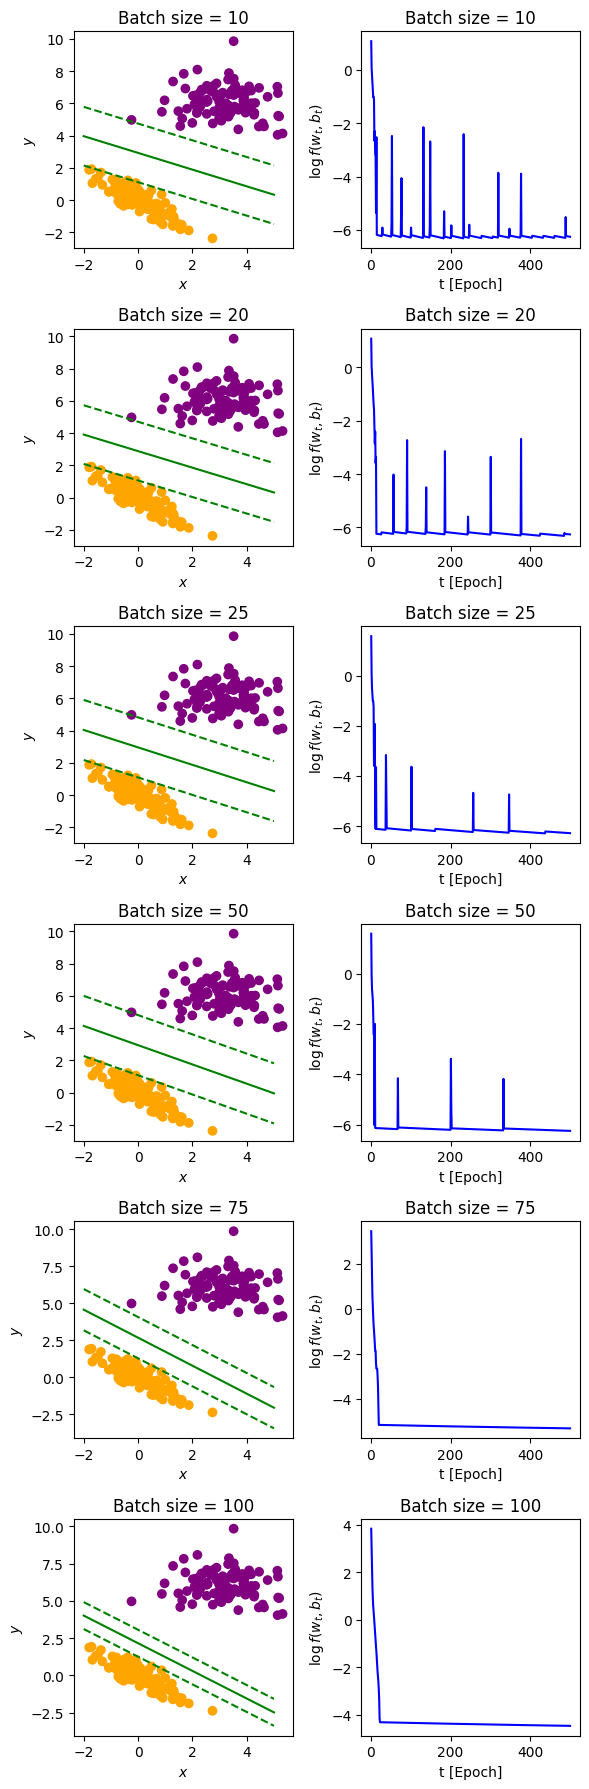

In [ ]:
# Create a separable dataset with 100 points per class
x, y = create_dataset(200, separable=True)

# Create a list with the values of dmu
batch_sizes = [10, 20, 25, 50, 75, 100]

lamb = 1.e-2
mu = 100.
dmu = 0.1
epochs = 500

# Solve the problem
fig, ax = plt.subplots(nrows=6, ncols=2, figsize=(6, 18))
for i, batch_size in enumerate(batch_sizes):
    w, b, f_values = batch_sgd(x, y, lamb, mu, dmu, epochs, batch_size=batch_size)

    # Plot the solution
    plot_solution(x, y, lamb, w, b, ax=ax[i, 0])
    ax[i, 0].set_title(f"Batch size = {batch_size:d}")

    # Plot the decay of the objective function
    plot_decay(f_values, ax=ax[i, 1])
    ax[i, 1].set_title(f"Batch size = {batch_size:d}")

    # Plot the
plt.tight_layout()
plt.show()

As before, the hyperplane correctly separates the data, and the support vectors are leaning on the hyperplanes at distance -1 and 1 of the separating hyperplane. It still works! The log graphs oscillates more before convergence as the batch sizes decrease. Using a smaller minibatch, the gradient estimate we compute over it is less representative of the entire dataset and the estimates have a higher variance, which make the model updates noisier since the gradient fluctutates more.

#### (3) Perform a plot of the logarithm of $f(\mathbf{w}, b)$ along each epoch (it is important to plot the logarithm of the function) for the stochastic gradient descent, minibatch and gradient descent (which is equivalent to use a mini-batch with a size equal to the number of samples). This allows you to see how fast each of the methods approaches the optimal solution and perform a comparison between the different experiments you have done.

The log plots are included in the exercises above.
